In [2]:
import plotly.io as pio

pio.renderers.default = "vscode+jupyterlab+notebook_connected"

## Introduction

This analysis explores the relationship between interest rate changes and stock market performance. 
We use the Federal Funds Effective Rate data from the Federal Reserve Bank and S&P 500 Adjusted Close data for stock performance.

## Part I: Setup

Import the libraries we need and retrieve the data.
The S&P 500 monthly data is sourced using the yfinance library.

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

Get the S&P 500 data and check.

In [5]:
sp500 = yf.download('^GSPC', start='1990-01-01', end='2023-12-31', interval='1mo')
print(sp500.head())  
print(sp500.tail())

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker           ^GSPC       ^GSPC       ^GSPC       ^GSPC       ^GSPC   
Date                                                                     
1990-01-01  329.079987  329.079987  360.589996  319.829987  353.399994   
1990-02-01  331.890015  331.890015  336.089996  322.100006  329.079987   
1990-03-01  339.940002  339.940002  344.489990  331.079987  331.890015   
1990-04-01  330.799988  330.799988  347.299988  327.760010  339.940002   
1990-05-01  361.230011  361.230011  362.260010  330.799988  330.799988   

Price           Volume  
Ticker           ^GSPC  
Date                    
1990-01-01  3793250000  
1990-02-01  2961970000  
1990-03-01  3283280000  
1990-04-01  2801220000  
1990-05-01  3596680000  
Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                             

Get the interest rate data and check. 

In [6]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=FEDFUNDS&scale=left&cosd=1990-01-01&coed=2023-12-31&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-23&revision_date=2024-11-23&nd=1954-07-01"
interest_rates = pd.read_csv(url)
print(interest_rates.head()) 

         DATE  FEDFUNDS
0  1990-01-01      8.23
1  1990-02-01      8.24
2  1990-03-01      8.28
3  1990-04-01      8.26
4  1990-05-01      8.18


## Part II: Data Cleaning and Merging

Extract the data we need and merge.
We will use the Adj Close GSPC in the first data set and merge it with the second data. 

In [7]:
print(sp500.columns)

MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [8]:
# adjust the column name of sp500 as it is multi index
sp500.columns = [' '.join(col).strip() for col in sp500.columns.values]
print(sp500.columns)

Index(['Adj Close ^GSPC', 'Close ^GSPC', 'High ^GSPC', 'Low ^GSPC',
       'Open ^GSPC', 'Volume ^GSPC'],
      dtype='object')


In [9]:
sp500 = sp500.reset_index()
print(sp500.columns)

Index(['Date', 'Adj Close ^GSPC', 'Close ^GSPC', 'High ^GSPC', 'Low ^GSPC',
       'Open ^GSPC', 'Volume ^GSPC'],
      dtype='object')


In [10]:
print(interest_rates.columns) 

Index(['DATE', 'FEDFUNDS'], dtype='object')


In [11]:
# make sure the data type of column "date" are the same
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])

In [12]:
# merge and make sure that the dates are aligned.
merged_data = pd.merge(
    interest_rates,
    sp500[['Date', 'Adj Close ^GSPC']],
    left_on='DATE',       
    right_on='Date',      
    how='left'            
)

print(merged_data.head())

        DATE  FEDFUNDS       Date  Adj Close ^GSPC
0 1990-01-01      8.23 1990-01-01       329.079987
1 1990-02-01      8.24 1990-02-01       331.890015
2 1990-03-01      8.28 1990-03-01       339.940002
3 1990-04-01      8.26 1990-04-01       330.799988
4 1990-05-01      8.18 1990-05-01       361.230011


In [13]:
# adjust to make the new dataframe look good.
merged_data = merged_data.drop(columns=['Date'])
merged_data.rename(columns={'Adj Close ^GSPC': 'SP500_Adj_Close'}, inplace=True)
print(merged_data.head())

        DATE  FEDFUNDS  SP500_Adj_Close
0 1990-01-01      8.23       329.079987
1 1990-02-01      8.24       331.890015
2 1990-03-01      8.28       339.940002
3 1990-04-01      8.26       330.799988
4 1990-05-01      8.18       361.230011


## Part III: Visualization 

We need two y axis for this as the unit of S&P 500 and interest rate is very different. 

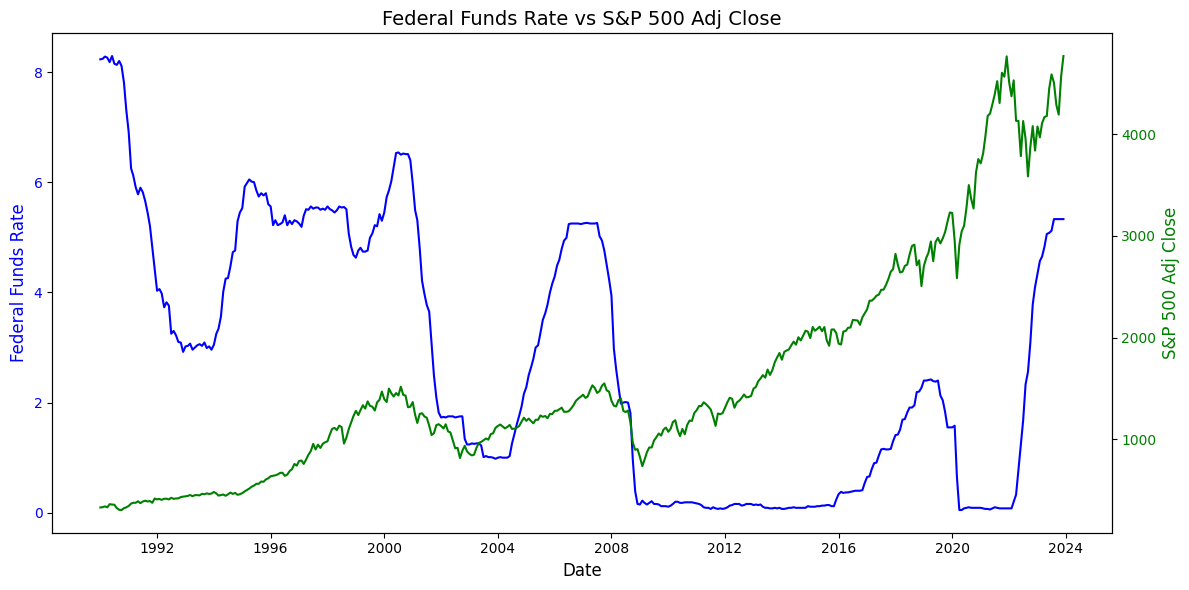

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['DATE'], merged_data['FEDFUNDS'], color='blue', label='Federal Funds Rate')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Federal Funds Rate', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(merged_data['DATE'], merged_data['SP500_Adj_Close'], color='green', label='S&P 500 Adj Close')
ax2.set_ylabel('S&P 500 Adj Close', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')


plt.title('Federal Funds Rate vs S&P 500 Adj Close', fontsize=14)
plt.xticks(rotation=45)

fig.tight_layout()
plt.show()

To make it clear, we focus on the 6 major interest rate cuts from 1990 to 2023.

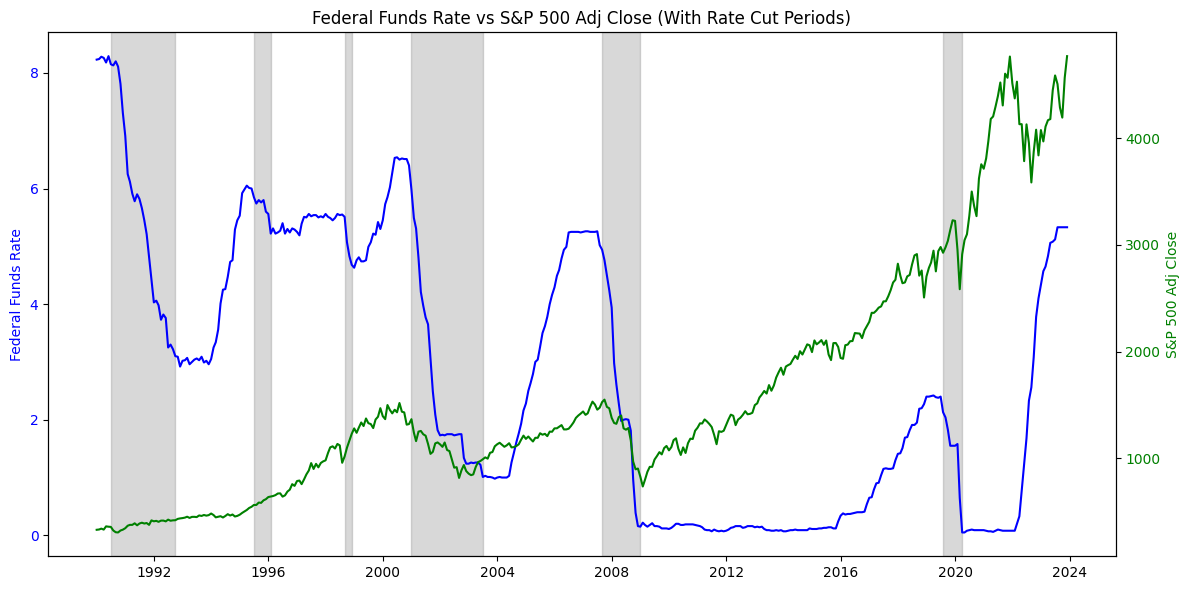

In [15]:
rate_cut_periods = [
    ('1990-07-01', '1992-09-30'),
    ('1995-07-01', '1996-01-31'),
    ('1998-09-01', '1998-11-30'),
    ('2001-01-01', '2003-06-30'),
    ('2007-09-01', '2008-12-31'),
    ('2019-08-01', '2020-03-31'),
]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['DATE'], merged_data['FEDFUNDS'], color='blue', label='Federal Funds Rate')
ax1.set_ylabel('Federal Funds Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(merged_data['DATE'], merged_data['SP500_Adj_Close'], color='green', label='S&P 500 Adj Close')
ax2.set_ylabel('S&P 500 Adj Close', color='green')
ax2.tick_params(axis='y', labelcolor='green')

for start, end in rate_cut_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

plt.title('Federal Funds Rate vs S&P 500 Adj Close (With Rate Cut Periods)')
fig.tight_layout()
plt.show()

In [16]:
filtered_data = []
for start, end in rate_cut_periods:
    period_data = merged_data[(merged_data['DATE'] >= start) & (merged_data['DATE'] <= end)]
    filtered_data.append(period_data)

summary = []
for i, (start, end) in enumerate(rate_cut_periods):
    data = filtered_data[i]
    fed_rate_drop = data['FEDFUNDS'].iloc[0] - data['FEDFUNDS'].iloc[-1]
    sp500_change = (data['SP500_Adj_Close'].iloc[-1] - data['SP500_Adj_Close'].iloc[0]) / data['SP500_Adj_Close'].iloc[0]
    summary.append({
        "Period": f"{start} to {end}",
        "Fed Rate Drop": round(fed_rate_drop, 2),
        "SP500 Change (%)": round(sp500_change * 100, 2)
    })
    
summary_df = pd.DataFrame(summary)
print(summary_df)

                     Period  Fed Rate Drop  SP500 Change (%)
0  1990-07-01 to 1992-09-30           4.93             17.31
1  1995-07-01 to 1996-01-31           0.29             13.16
2  1998-09-01 to 1998-11-30           0.68             14.42
3  2001-01-01 to 2003-06-30           4.76            -28.66
4  2007-09-01 to 2008-12-31           4.78            -40.84
5  2019-08-01 to 2020-03-31           1.48            -11.68


## Part IV: Summary 

In the first three major rate cuts (1990-1992, 1995-1996, 1998), the stock market exhibited positive performance.

In the last three rate cut periods (2001-2003, 2007-2008, 2019-2020), stock performance was negative.

The relationship between interest rate cuts and stock market performance is not definitive and varies depending on the context. 
These variations may stem from a range of factors, including macroeconomic conditions, investor sentiment, etc. For instance, rate cuts during periods of economic weakness or financial crises may signal underlying vulnerabilities, leading to weaker stock performance. Conversely, rate cuts in a stable or recovering economy may boost market confidence and thus drive positive stock performance. Understanding this relationship requires further exploration during each period.